Filtrado eventos de seguridad en forma conservativa con Learninspy
===========================
<img style="display: inline;" src="docs/img/Learninspy-logo_grande2.png" width="300" />


### Metodología:
* Modelar el *baseline* de los datos para obtener un **filtrado conservativo**
    * Recall máximo posible descartando lo normal.
    * Precision máxima posible reteniendo lo anormal.
* Datos usados: **NSL-KDD dataset** (network traffic)

#### Referencias:
--------------
> Tavallaee, M., Bagheri, E., Lu, W., and Ghorbani, A. A. (2009). A detailed analysis of the KDD CUP 99 data set. In Proceedings of the Second IEEE Symposium on Computational Intelligence for Security and Defence Applications 2009.

### Dependencias

In [1]:
# Librerias de Python
import time
import copy

# Dependencias internas
from learninspy.core.autoencoder import StackedAutoencoder
from learninspy.core.model import NetworkParameters
from learninspy.core.optimization import OptimizerParameters
from learninspy.core.stops import criterion
from learninspy.utils.data import split_data, label_data
from learninspy.utils.data import StandardScaler, LocalLabeledDataSet
from learninspy.utils.evaluation import ClassificationMetrics
from learninspy.utils.plots import plot_neurons, plot_fitting, plot_confusion_matrix

# Dependencias externas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

2016-09-03 22:20:15,396 - learninspy.context - INFO - Contexto de Spark inicializado.
INFO:learninspy.context:Contexto de Spark inicializado.


### Carga de datos

In [2]:
pathtrain = "/home/leeandro04/Documentos/Datos/KDD/NSL_KDD/20 Percent Training Set.csv"
pathtest = "/home/leeandro04/Documentos/Datos/KDD/NSL_KDD/KDDTest+.csv"
pathtest21 = "/home/leeandro04/Documentos/Datos/KDD/NSL_KDD/KDDTest-21.txt"

alltrain = pd.read_csv(pathtrain, header=None)
test = pd.read_csv(pathtest, header=None)
test21 = pd.read_csv(pathtest21, header=None)

In [3]:
alltrain

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [4]:
# Dropping
drop = [0, 1, 2, 3, 4, 5, 6, 7, 8,  # Basic Features
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, # Content Features
        ]

for d in drop:
    alltrain.drop(d, axis=1, inplace=True)
    test.drop(d, axis=1, inplace=True)
    test21.drop(d, axis=1, inplace=True)

In [5]:
alltrain.describe()

,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42
count,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769,19.487695
std,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333,2.328541
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [6]:
# Explicacion de ataques en los datos etiquetados de KDDTrain+
dict_attacks = {'dos': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'],
                'u2r': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit'],
                'r2l': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster'],
                'probe': ['ipsweep', 'nmap', 'portsweep', 'satan']}

### Procesamiento y etiquetado de datos

In [7]:
# Separo lo normal de los ataques en base a un Ground Truth (columna de etiquetas)
normal = alltrain[alltrain[41] == 'normal']
attack = alltrain[alltrain[41] != 'normal']

# Tiro las columnas de etiquetas
normal = normal.ix[:, :40]
attack = attack.ix[:, :40]

# Etiqueto datos
normal = label_data(normal.values, [0]*len(normal.values))
attack = label_data(attack.values, [1]*len(attack.values))

train, valid = split_data(normal, fractions=[0.7, 0.3])

print "Dimension de características: ", len(normal[0].features)

print "Cantidad de ejemplos normales: ", len(normal)
print "Cantidad de ejemplos de ataques: ", len(attack)

print "Cantidad de train: ", len(train)
print "Cantidad de valid: ", len(valid)

Dimension de características:  19
Cantidad de ejemplos normales:  13449
Cantidad de ejemplos de ataques:  11743
Cantidad de train:  9414
Cantidad de valid:  4035


### Configuración del modelo y su optimización

In [8]:
# Defino configuración del Stacked AutoEncoder y entreno
net_params = NetworkParameters(units_layers=[19, 10, 2], activation='ReLU', classification=True, 
                               dropout_ratios=[0.2, 0.0], strength_l1=1e-6, strength_l2=5e-5)

saekdd = StackedAutoencoder(net_params, dropout=[0.0, 0.0])

In [9]:
# Para el pre-entrenamiento
local_stops_sae = [criterion['MaxIterations'](30),
                   criterion['AchieveTolerance'](0.95, key='hits')]

global_stops_sae = [criterion['MaxIterations'](20),
                criterion['AchieveTolerance'](0.95, key='hits')]

opt_params_sae = OptimizerParameters(algorithm='Adadelta', 
                                 options={'step-rate': 1, 'decay': 0.995, 'momentum': 0.7, 'offset': 1e-8},
                                 stops=local_stops_sae, merge_criter='w_avg', merge_goal='hits')

In [10]:
# Para el ajuste fino
local_stops_ft = [criterion['MaxIterations'](5),
               criterion['AchieveTolerance'](0.9, key='hits')]

global_stops_ft = [criterion['MaxIterations'](20),
                criterion['AchieveTolerance'](0.85, key='hits')]

opt_params_ft = OptimizerParameters(algorithm='GD', 
                                 options={'step-rate': 1e-3, 'momentum': 0.9, 'momentum_type': 'nesterov'},
                                 stops=local_stops_ft, merge_criter='w_avg')

### Pre-entrenamiento

In [11]:
hits_valid = saekdd.fit(train, valid, mini_batch=20, parallelism=10, valid_iters=1,
                         stops=global_stops_sae, optimizer_params=opt_params_sae, reproducible=True)

2016-09-03 22:20:17,419 - learninspy.core.autoencoder - INFO - Entrenando AutoEncoder -> In: 19, Hidden: 10
2016-09-03 22:20:30,242 - learninspy.core.model - INFO - Epoca 1 realizada en  11.8271s. Hits en train: 0.52783220854. Hits en valid: 0.53041541754
2016-09-03 22:20:35,204 - learninspy.core.model - INFO - Epoca 2 realizada en   4.3024s. Hits en train: 0.53474074125. Hits en valid: 0.53729753647
2016-09-03 22:20:39,695 - learninspy.core.model - INFO - Epoca 3 realizada en   3.8260s. Hits en train: 0.94991845157. Hits en valid: 0.95515215913
2016-09-03 22:20:41,759 - learninspy.core.model - INFO - Ajuste total realizado en  19.9555s. Hits en train: 0.94991845157. Hits en valid: 0.95515215913
2016-09-03 22:20:42,568 - learninspy.core.autoencoder - INFO - Entrenando Capa de salida -> In: 10, Out: 2
2016-09-03 22:20:44,731 - learninspy.core.model - INFO - Epoca 1 realizada en   1.8529s. Hits en train: 1.00000000000. Hits en valid: 1.00000000000
2016-09-03 22:20:45,658 - learninspy.cor

In [12]:
hits_attack, predictions = saekdd.evaluate(attack[1000:5000], predictions=True)
print "Hits de valid: ", hits_valid
print "Hits de ataques: ", hits_attack
print "Accuracy de ataques: ", len(filter(lambda (lp, p): lp.label == p, zip(attack[1000:5000], predictions))) / float(len(attack[1000:5000]))

Hits de valid:  1.0
Hits de ataques:  0.5
Accuracy de ataques:  0.0


### Ajuste fino

In [13]:
train2, valid2 = split_data(train+attack[:1000], fractions=[0.7, 0.3])
hits_total = saekdd.finetune(train2, valid2, mini_batch=20, parallelism=10, stops=global_stops_ft, valid_iters=1,
                          optimizer_params=opt_params_sae, keep_best=True)

2016-09-03 22:20:49,357 - learninspy.core.model - INFO - Epoca 1 realizada en   2.8010s. Hits en train: 0.80552063666. Hits en valid: 0.80339035213
2016-09-03 22:20:52,091 - learninspy.core.model - INFO - Epoca 2 realizada en   2.3564s. Hits en train: 0.81669137194. Hits en valid: 0.82637093256
2016-09-03 22:20:55,329 - learninspy.core.model - INFO - Epoca 3 realizada en   2.8534s. Hits en train: 0.86132727994. Hits en valid: 0.86648207561
2016-09-03 22:20:56,493 - learninspy.core.model - INFO - Ajuste total realizado en   8.0109s. Hits en train: 0.86132727994. Hits en valid: 0.86648207561


### Resultados

Metricas: 
Total of normal events:  4035
Precision of normal:  0.586130415496
Recall of normal:  0.982403965304
F1-Score of normal:  0.734210038896
Accuracy of normal:  0.580040971613

Total of attack events:  4000
Precision of attacks:  0.991141609482
Recall of attacks:  0.739458251885
F1-Score of attacks:  0.846998613925
Accuracy of attacks:  0.734603292029

Precision of total:  0.788636012489
Recall of total:  0.860931108594
F1-Score of total:  0.823199332518
Accuracy of total:  0.805792394099


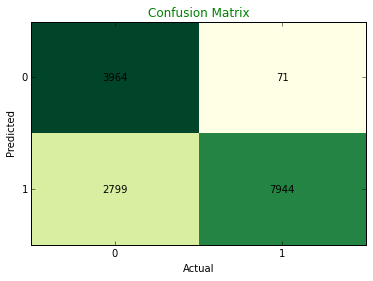

Reduction of total:  45.7639734741 %


In [14]:
print "Metricas: "
hits, predictions = saekdd.evaluate(valid+attack[1000:], predictions=True)

labels = map(lambda lp: float(lp.label), valid+attack[1000:])
metrics = ClassificationMetrics(zip(predictions, labels), 2)

print "Total of normal events: ", len(valid)
print "Precision of normal: ", metrics.precision(label=0)
print "Recall of normal: ", metrics.recall(label=0)
print "F1-Score of normal: ", metrics.f_measure(label=0)
print "Accuracy of normal: ", metrics.accuracy(label=0)
print ""
print "Total of attack events: ", len(attack[1000:5000])
print "Precision of attacks: ", metrics.precision(label=1)
print "Recall of attacks: ", metrics.recall(label=1)
print "F1-Score of attacks: ", metrics.f_measure(label=1)
print "Accuracy of attacks: ", metrics.accuracy(label=1)
print ""
print "Precision of total: ", metrics.precision()
print "Recall of total: ", metrics.recall()
print "F1-Score of total: ", metrics.f_measure()
print "Accuracy of total: ", metrics.accuracy()

plot_confusion_matrix(metrics.confusion_matrix(), show=True)

reduction = 1. - (metrics.confusion_matrix()[0][1]+metrics.confusion_matrix()[1][1]) / float(sum(sum(metrics.confusion_matrix())))
print "Reduction of total: ", reduction * 100,"%"

### Guardar modelo

In [15]:
filename = '/tmp/model/nsl-kdd_learninspy_conft'
saekdd.save(filename)

print "Modelo StackedAutoencoder:"
print str(saekdd.params)
print "Optimización no-supervisada:"
print str(opt_params_sae)
print "Fine-tuning supervisado:"
print str(opt_params_ft)


Modelo StackedAutoencoder:
Layer 0 with 19 neurons, using ReLU activation and 0.2 ratio of DropOut.
Layer 1 with 10 neurons, using ReLU activation and 0.0 ratio of DropOut.
Layer 2 with 2 neurons, using Softmax activation.
The loss is CrossEntropy for a task of classification.
L1 strength is 1e-06 and L2 strength is 5e-05.

Optimización no-supervisada:
The algorithm used is Adadelta with the next parameters:
offset: 1e-08
step-rate: 1
momentum: 0.7
decay: 0.995
The stop criteria used for optimization is: 
Stop at a maximum of 30 iterations.
Stop when a tolerance of 0.95 is achieved/exceeded in hits.

Fine-tuning supervisado:
The algorithm used is GD with the next parameters:
momentum_type: nesterov
step-rate: 0.001
momentum: 0.9
The stop criteria used for optimization is: 
Stop at a maximum of 5 iterations.
Stop when a tolerance of 0.9 is achieved/exceeded in hits.



### KDDTest+ Dataset

In [16]:
test.describe()

,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42
count,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000,22543.000000
mean,79.028035,31.125449,0.102928,0.103640,0.238474,0.235189,0.740374,0.094057,0.098115,193.866699,140.756465,0.608747,0.090519,0.132236,0.019639,0.097818,0.099430,0.233382,0.226693,18.018498
std,128.542091,89.064362,0.295373,0.298337,0.416124,0.416221,0.412482,0.259131,0.253550,94.036867,111.782902,0.435681,0.220701,0.306253,0.085396,0.273144,0.281872,0.387237,0.400881,4.269705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
50%,8.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,123.500000,16.000000,0.000000,0.000000,0.250000,0.075000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000,21.000000
max,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [17]:
# Separo lo normal de los ataques en base a un Ground Truth (columna de etiquetas)
normal = test[test[41] == 'normal']
anomal = test[test[41] != 'normal']

# Tiro las columnas de etiquetas
normal = normal.ix[:, :40]
anomal = anomal.ix[:, :40]

# Etiqueto datos
normal = label_data(normal.values, [0]*len(normal.values))
anomal = label_data(anomal.values, [1]*len(anomal.values))

### Resultados

Metricas: 
Precision of normal:  0.565271241021
Recall of normal:  0.940061791967
F1-Score of normal:  0.706009745533
Accuracy of normal:  0.545606694561

Precision of attacks:  0.908991399531
Recall of attacks:  0.452972804488
F1-Score of attacks:  0.604639068026
Accuracy of attacks:  0.43332090943

Precision of total:  0.737131320276
Recall of total:  0.696517298228
F1-Score of total:  0.71624902924
Accuracy of total:  0.662777802422


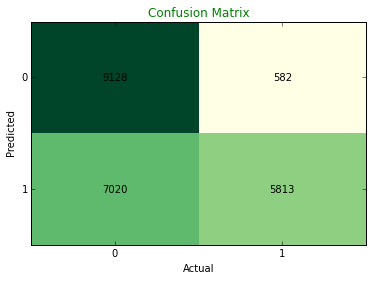

Reduction of total:  71.6319921927 %


In [18]:
print "Metricas: "
hits, predictions = saekdd.evaluate(normal+anomal, predictions=True)
labels = map(lambda lp: float(lp.label), normal+anomal)
metrics = ClassificationMetrics(zip(predictions, labels), 2)
print "Precision of normal: ", metrics.precision(label=0)
print "Recall of normal: ", metrics.recall(label=0)
print "F1-Score of normal: ", metrics.f_measure(label=0)
print "Accuracy of normal: ", metrics.accuracy(label=0)
print ""
print "Precision of attacks: ", metrics.precision(label=1)
print "Recall of attacks: ", metrics.recall(label=1)
print "F1-Score of attacks: ", metrics.f_measure(label=1)
print "Accuracy of attacks: ", metrics.accuracy(label=1)
print ""
print "Precision of total: ", metrics.precision()
print "Recall of total: ", metrics.recall()
print "F1-Score of total: ", metrics.f_measure()
print "Accuracy of total: ", metrics.accuracy()

plot_confusion_matrix(metrics.confusion_matrix(), show=True)

reduction =  1. - (metrics.confusion_matrix()[0][1]+metrics.confusion_matrix()[1][1]) / float(sum(sum(metrics.confusion_matrix())))
print "Reduction of total: ", reduction * 100,"%"

### KDDTest -21 Dataset

In [19]:
test21.describe()

,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42
count,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000,11850.000000
mean,94.116118,48.269451,0.113841,0.114590,0.274313,0.268355,0.753008,0.157149,0.096762,213.945401,117.541603,0.539597,0.148986,0.206493,0.024465,0.104181,0.106697,0.263952,0.252209,15.326835
std,153.418960,119.213908,0.305945,0.309216,0.430353,0.430249,0.399044,0.338761,0.278665,82.203728,106.563438,0.423370,0.288758,0.379193,0.114234,0.265086,0.278549,0.377337,0.403039,4.407479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,255.000000,12.000000,0.070000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,83.000000,0.530000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,17.000000
75%,132.000000,16.000000,0.000000,0.000000,0.840000,0.797500,1.000000,0.060000,0.000000,255.000000,250.000000,1.000000,0.070000,0.090000,0.000000,0.010000,0.000000,0.560000,0.520000,18.000000
max,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000


In [20]:
# Separo lo normal de los ataques en base a un Ground Truth (columna de etiquetas)
normal = test21[test21[41] == 'normal']
anomal = test21[test21[41] != 'normal']

# Tiro las columnas de etiquetas
normal = normal.ix[:, :40]
anomal = anomal.ix[:, :40]

# Etiqueto datos
normal = label_data(normal.values, [0]*len(normal.values))
anomal = label_data(anomal.values, [1]*len(anomal.values))

### Resultados

Metricas: 
Precision of normal:  0.187003272557
Recall of normal:  0.743494423792
F1-Score of normal:  0.298841987299
Accuracy of normal:  0.175669740887

Precision of attacks:  0.832422586521
Recall of attacks:  0.282738709012
F1-Score of attacks:  0.42210591133
Accuracy of attacks:  0.267512195122

Precision of total:  0.509712929539
Recall of total:  0.513116566402
F1-Score of total:  0.511409084884
Accuracy of total:  0.36641350211


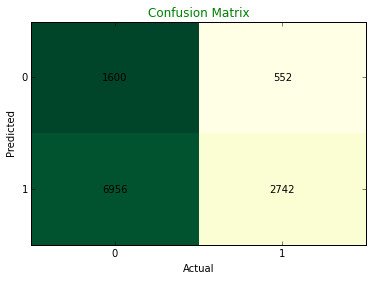

Reduction of total:  72.2025316456 %


In [21]:
print "Metricas: "
hits, predictions = saekdd.evaluate(normal+anomal, predictions=True)
labels = map(lambda lp: float(lp.label), normal+anomal)
metrics = ClassificationMetrics(zip(predictions, labels), 2)
print "Precision of normal: ", metrics.precision(label=0)
print "Recall of normal: ", metrics.recall(label=0)
print "F1-Score of normal: ", metrics.f_measure(label=0)
print "Accuracy of normal: ", metrics.accuracy(label=0)
print ""
print "Precision of attacks: ", metrics.precision(label=1)
print "Recall of attacks: ", metrics.recall(label=1)
print "F1-Score of attacks: ", metrics.f_measure(label=1)
print "Accuracy of attacks: ", metrics.accuracy(label=1)
print ""
print "Precision of total: ", metrics.precision()
print "Recall of total: ", metrics.recall()
print "F1-Score of total: ", metrics.f_measure()
print "Accuracy of total: ", metrics.accuracy()

plot_confusion_matrix(metrics.confusion_matrix(), show=True)

reduction = 1. - (metrics.confusion_matrix()[0][1]+metrics.confusion_matrix()[1][1]) / float(sum(sum(metrics.confusion_matrix())))
print "Reduction of total: ", reduction * 100,"%"

### Gráficas

Desempeño del ajuste fino


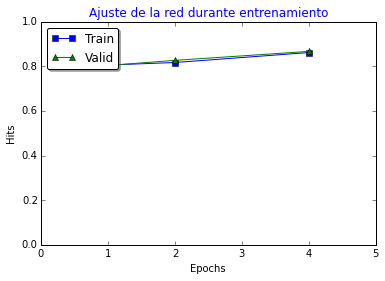

Pesos sinápticos del AE


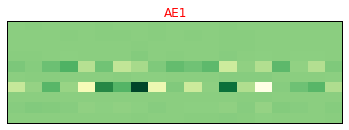

In [22]:
from learninspy.utils.plots import plot_fitting

print "Desempeño del ajuste fino"
plot_fitting(saekdd)

print "Pesos sinápticos del AE"
plot_neurons(saekdd)

Patrón original: 
[3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,117.0,145.0,0.06,0.04,0.06,0.48,0.0,0.0,0.03,0.0]
Patrón codificado: 
[0.0, 0.0, 43.161488928113464, 44.817419435865816, 0.0, 48.610975653072508, 48.43941142455953, 162.11235312536132, 31.078874949638251, 70.374595772717072]

Mediana de features originales


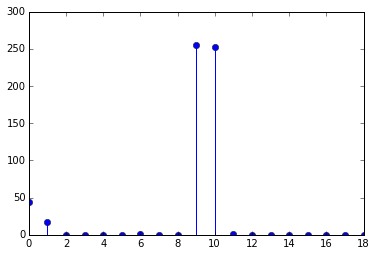


Mediana de features codificadas


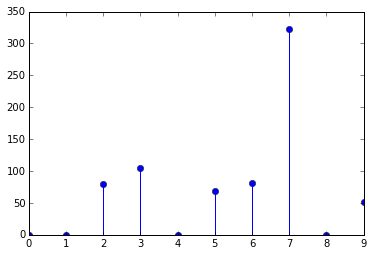

In [23]:
data = normal
x = data[100].features
en1 = saekdd.list_layers[0].encode(x).matrix
print "Patrón original: "
print x
print "Patrón codificado: " 
print list(en1.T[0])
print ""

median_feat = np.median(map(lambda r: r.features, data), 0)
median_encod = np.median(map(lambda r: saekdd.list_layers[0].encode(r.features).matrix.T[0], data), 0)

print "Mediana de features originales"
plt.stem(median_feat)
plt.show()
print ""

print "Mediana de features codificadas"
plt.stem(median_encod)
plt.show()